# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the [Human Value Detection challenge](https://aclanthology.org/2022.acl-long.306/).

## Problem definition

Arguments are paired with their conveyed human values.

Arguments are in the form of **premise** $\rightarrow$ **conclusion**.

### Example:

**Premise**: *``fast food should be banned because it is really bad for your health and is costly''*

**Conclusion**: *``We should ban fast food''*

**Stance**: *in favour of*

<center>
    <img src="images/human_values.png" alt="human values" />
</center>

# [Task 1 - 0.5 points] Corpus

Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

The challenge offers several corpora for evaluation and testing.

You are going to work with the standard training, validation, and test splits.

#### Arguments
* arguments-training.tsv
* arguments-validation.tsv
* arguments-test.tsv

#### Human values
* labels-training.tsv
* labels-validation.tsv
* labels-test.tsv

### Example

#### arguments-*.tsv
```

Argument ID    A01005

Conclusion     We should ban fast food

Stance         in favor of

Premise        fast food should be banned because it is really bad for your health and is costly.
```

#### labels-*.tsv

```
Argument ID                A01005

Self-direction: thought    0
Self-direction: action     0
...
Universalism: objectivity: 0
```

### Splits

The standard splits contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

### Instructions

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

# [Task 2 - 2.0 points] Model definition

You are tasked to define several neural models for multi-label classification.

<center>
    <img src="images/model_schema.png" alt="model_schema" />
</center>

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

In [1]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [2]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00


In [3]:
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
!pip install transformers[torch]

In [1]:
import pandas as pd
import numpy as np
import torch
import transformers
import torch.nn as nn
from torch.utils.data import DataLoader
import accelerate
from datasets import *
from transformers import AutoTokenizer, BertForSequenceClassification, PreTrainedTokenizerFast, DefaultDataCollator, Trainer, TrainingArguments
from transformers.optimization import AdamW
import random
import matplotlib.pyplot as plt
from transformers.optimization import get_scheduler
import matplotlib.colors as mcolors
from sklearn.metrics import confusion_matrix, classification_report, f1_score,  precision_recall_fscore_support
from sklearn.utils import class_weight
import os
import warnings
warnings.filterwarnings("ignore")
from transformers import logging
logging.set_verbosity_error()
import tqdm.notebook as tq


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

#HYPERPARAMETERS
model_checkpoint = 'prajjwal1/bert-tiny'
#MAX_LEN = 200
NUM_LABELS = 4
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-05
DROPOUT = 0.2
WEIGHT_DECAY = 0.01

Using cuda device


In [3]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    transformers.set_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
# Load the tokenizer
print(f'Loading tokenizer ...')
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
assert isinstance(tokenizer, PreTrainedTokenizerFast)
print('Tokenizer loaded.')

Loading tokenizer ...


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Tokenizer loaded.


In [5]:
#for colab
colab = True
print(f"Loading data...")
if colab:
    #for colab
    from google.colab import files
    import zipfile


    uploaded = files.upload()


    zip_filename = next(iter(uploaded))


    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    path_labels_data = "/content/labels_data"
    path_arguments_data = "/content/arguments_data"
else:
    path_labels_data = ".\labels_data"
    path_arguments_data = ".\\arguments_data"



def load_file():
    '''Load the file and return the data and labels for training, testing and validation'''

    train_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-training.tsv'), sep='\t')
    test_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-test.tsv'), sep='\t')
    valid_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-validation.tsv'), sep='\t')
    train_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-training.tsv'),sep='\t')
    test_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-test.tsv'),sep='\t')
    valid_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-validation.tsv'),sep='\t')

    return (train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels)



(train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels) = load_file()
print("Data loaded.")

Loading data...


Saving files_ass2.zip to files_ass2.zip
Data loaded.


In [6]:
# Merge the data and labels
def merge_df(data, labels):
    return pd.merge(data, labels, on='Argument ID')

train_df_merged = merge_df(train_data, train_labels)
val_df_merged = merge_df(valid_data, valid_labels)
test_df_merged = merge_df(test_data, test_labels)

level2_to_level3 = {
    'openness_to_change':["Self-direction: thought", "Self-direction: action","Stimulation", "Hedonism"],
    'self_enhancement':['Hedonism','Achievement', 'Power: dominance', 'Power: resources','Face'],
    'conservation': ['Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal','Humility'],
    'self_transcendence':['Humility', 'Benevolence: caring', 'Benevolence: dependability','Universalism: concern', 'Universalism: nature','Universalism: tolerance', 'Universalism: objectivity']
}

def lv3_labels(df):
    """
    Function to aggregate specified columns by taking the logical OR between their values.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: A new DataFrame with aggregated values.
    """

    # Create a new DataFrame to store aggregated values
    new_df = pd.DataFrame()

    # Iterate over the mapping and compute logical OR for each set of columns
    for new_column, columns_to_aggregate in level2_to_level3.items():
        new_df[new_column] = df[columns_to_aggregate].apply(lambda row: any(row), axis=1).astype(int)  # Convert boolean to int

    # Drop the original columns used for aggregation
    df.drop(columns=[col for cols in level2_to_level3.values() for col in cols], inplace=True)

    # Concatenate new DataFrame with the remaining columns of the original DataFrame
    new_df = pd.concat([df, new_df], axis=1)

    return new_df

df_train = lv3_labels(train_df_merged)
df_val = lv3_labels(val_df_merged)
df_test = lv3_labels(test_df_merged)

In [7]:
def refine_df(df):
    new_df = df.copy()
    new_df["Stance"] = df['Stance'].replace({'in favor of': 1, 'against': 0})
    new_df.drop(df.columns[4:], axis=1, inplace=True)
    new_df['labels'] = df.iloc[:, 4:].apply(lambda x: np.array(list(x)), axis=1)
    return new_df

df_train = refine_df(df_train)
df_test = refine_df(df_test)
df_val = refine_df(df_val)

In [8]:
featurez = ['Conclusion', 'Premise', 'Stance', 'labels']

# Dataframes to Datasets
train_df_to_ds = df_train[featurez]
val_df_to_ds = df_val[featurez]
test_df_to_ds = df_test[featurez]

train_df_to_ds = train_df_to_ds.rename(columns={'Conclusion': 'conclusion', 'Premise': 'premise', 'Stance': 'stance'})
val_df_to_ds = val_df_to_ds.rename(columns={'Conclusion': 'conclusion', 'Premise': 'premise', 'Stance': 'stance'})
test_df_to_ds = test_df_to_ds.rename(columns={'Conclusion': 'conclusion', 'Premise': 'premise', 'Stance': 'stance'})


In [9]:
tclengths = [len(tokenizer(x)["input_ids"]) for x in train_df_to_ds['conclusion']]
tplengths = [len(tokenizer(x)["input_ids"]) for x in train_df_to_ds['premise']]

vclengths = [len(tokenizer(x)["input_ids"]) for x in val_df_to_ds['conclusion']]
vplengths = [len(tokenizer(x)["input_ids"]) for x in val_df_to_ds['premise']]

WC_MAX_LEN = max(tclengths+vclengths)
WCP_MAX_LEN = WC_MAX_LEN + max(tplengths+tplengths) + 1
WCPS_MAX_LEN = WCP_MAX_LEN + 2


## Create Dataset and DataLoaders

In [10]:
#define BertDataset:

class MultilabelDataset(torch.utils.data.Dataset):
    def __init__(self,df:pd.DataFrame, tokenizer:AutoTokenizer, max_len:int):
        self.tokenizer = tokenizer
        self.df = df
        self.conclusion = df.conclusion
        self.premise = df.premise
        self.stance = torch.tensor(df['stance'].values.astype(float), dtype=torch.float)
        self.max_len = max_len
        self.labels = torch.tensor(np.stack(df['labels'].tolist()), dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        conclusion = self.conclusion[index]
        premise = self.premise[index]

        inputs_c = self.tokenizer.encode_plus(
            conclusion,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'
        )

        inputs_p = self.tokenizer.encode_plus(
            premise,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'
        )

        ids_c = inputs_c['input_ids'].flatten()
        mask_c = inputs_c['attention_mask'].flatten()
        token_type_ids_c = inputs_c['token_type_ids'].flatten()

        ids_p = inputs_p['input_ids'].flatten()
        mask_p = inputs_p['attention_mask'].flatten()
        token_type_ids_p = inputs_p['token_type_ids'].flatten()

        return {'ids_c' : ids_c,
                'mask_c' : mask_c,
                'token_type_ids_c' : token_type_ids_c,
                'ids_p':ids_p,
                'mask_p':mask_p,
                'token_type_ids_p': token_type_ids_p,
                'stance' : self.stance[index],
                'labels' : self.labels[index]}

wc_datasets = DatasetDict()
wc_datasets['train'] = MultilabelDataset(train_df_to_ds, tokenizer, WC_MAX_LEN)
wc_datasets['validation'] = MultilabelDataset(val_df_to_ds, tokenizer, WC_MAX_LEN)
wc_datasets['test'] = MultilabelDataset(test_df_to_ds, tokenizer, WC_MAX_LEN)


In [11]:
train_loader = DataLoader(wc_datasets['train'], batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(wc_datasets['validation'], batch_size=VALID_BATCH_SIZE, shuffle=False)

In [12]:
# Class Weights
def compute_class_weights_from_df(df):

    labels = df['labels'].tolist()
    labels_array = np.array([np.array(label) for label in labels])

    class_frequencies = np.sum(labels_array, axis=0) / len(labels_array)
    inverse_class_frequencies = 1 / class_frequencies

    return inverse_class_frequencies

## Defining Models

In [13]:
class RandomUniformClassifier(nn.Module):
    def __init__(self, NUM_LABELS):
        super(RandomUniformClassifier, self).__init__()
        self.NUM_LABELS = NUM_LABELS

    def forward(self, inputs):
        batch_size = inputs['ids_c'].shape[0]
        return torch.rand(batch_size, self.NUM_LABELS)



In [15]:
class MajorityClassifier(nn.Module):
    def __init__(self, num_categories: int):

        super(MajorityClassifier, self).__init__()
        self.num_categories = num_categories
        self.majority_classes = torch.zeros(num_categories)

    def forward(self, inputs, *args):

        batch_size = inputs['ids_c'].shape[0]
        return self.majority_classes.repeat(batch_size , 1)

    def fit(self, train_loader, *args):

        for batch in train_loader:
            labels = batch['labels']
            for i in range(self.num_categories):
                self.majority_classes[i] += (labels[:, i] > 0.5).sum()

        self.majority_classes = (self.majority_classes > (len(train_loader.dataset) / 2)).float()
        return self.majority_classes


In [14]:

class MultilabelClassifier(nn.Module):
    def __init__(self, num_labels, drop_out=0.1, model_type="base"):
        super(MultilabelClassifier, self).__init__()
        self.num_labels = num_labels
        self.model_type = model_type

        self.bert_conclusion = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=self.num_labels,output_hidden_states=True)

        if model_type != "base":
            self.bert_premise = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=self.num_labels,output_hidden_states=True)

        if model_type == "bert_w_cp":
            self.hidden_dim = self.bert_conclusion.config.hidden_size * 2

        elif model_type == "bert_w_cps":
            self.hidden_dim = (self.bert_conclusion.config.hidden_size * 2) + 1

        else:
            self.hidden_dim = self.bert_conclusion.config.hidden_size


        self.dropout = nn.Dropout(drop_out)
        self.dense = nn.Linear(self.hidden_dim, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        # Extracting data for conclusion
        ids_c = inputs['ids_c'].to(device)
        mask_c = inputs['mask_c'].to(device)
        token_type_ids_c = inputs['token_type_ids_c'].to(device)

        # Extracting data for premise
        ids_p = inputs['ids_p'].to(device)
        mask_p = inputs['mask_p'].to(device)
        token_type_ids_p = inputs['token_type_ids_p'].to(device)

        conclusion_outputs = self.bert_conclusion(input_ids=ids_c, attention_mask=mask_c, token_type_ids=token_type_ids_c)
        pooled_output_c = conclusion_outputs.hidden_states[-1][:, 0, :]


        if self.model_type != "base":
            premise_outputs = self.bert_premise(input_ids=ids_p, attention_mask=mask_p, token_type_ids=token_type_ids_p)
            pooled_output_cp = premise_outputs.hidden_states[-1][:, 0, :]

        if self.model_type == "bert_w_cp":
            output = torch.cat((pooled_output_c, pooled_output_cp), dim=1)
        elif self.model_type == "bert_w_cps":
            stance = inputs['stance']
            output = torch.cat((pooled_output_c, pooled_output_cp, stance), dim=1)
        else:
            output = pooled_output_c


        output = self.dropout(output)
        output = self.dense(output)
        output = self.sigmoid(output)
        return output


## Defining Loss and Metric

In [16]:
class WeightedLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedLoss, self).__init__()
        self.register_buffer('class_weights', class_weights)

    def forward(self, inputs, targets):
        loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, weight=self.class_weights.to(inputs.device))
        return loss


In [17]:
#F1 score
class F1Macro:
    def __init__(self, threshold=0.5, print_per_category=False):
        self.threshold = threshold
        self.print_per_category = print_per_category

    def compute(self, labels, predictions):

        binary_predictions = (predictions.cpu() > self.threshold).int().detach().numpy()
        labels = labels.cpu().detach().numpy()

        f1_macro = f1_score(y_true=labels, y_pred=binary_predictions, average='macro')

        if self.print_per_category:
            # Print per-category F1 scores
            per_category_scores = precision_recall_fscore_support(labels, binary_predictions, average=None)
            print("Per-category F1 scores:")
            for i, score in enumerate(per_category_scores[2]):
                print(f"Category {i+1}: {score}")

        return f1_macro

def compute_metrics(labels, predictions):
    f1_macro_computer = F1Macro()
    macro_f1_score = f1_macro_computer.compute(labels, predictions)
    return {"macro_f1": macro_f1_score}

In [36]:

def train_and_validate(epochs, model, train_dataloader, val_dataloader, loss_fn, seed,path_to_ckp = None, load_model=False,eval_only=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()

    if not eval_only :
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
        scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=len(wc_datasets['train']) // TRAIN_BATCH_SIZE * epochs,
        )

    train_losses = []
    val_losses = []
    f1_scores = []
    val_f1_scores = []


    if not load_model:
        if not eval_only :
          for epoch in range(1, epochs + 1):
                model.train()
                losses = []
                f1_scores_epoch = []

                for batch in tqdm(train_dataloader):
                    optimizer.zero_grad()
                    targets = batch['labels'].float().to(device)
                    batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

                    outputs = model(batch)
                    inputs = outputs

                    loss = loss_fn(inputs, targets)
                    losses.append(loss.item())


                    f1 = compute_metrics(labels=targets, predictions=inputs)
                    f1_scores_epoch.append(f1)

                    loss.backward()
                    optimizer.step()
                    if scheduler:
                        scheduler.step()


                mean_loss = np.mean(losses)
                mean_f1 = np.mean([score["macro_f1"] for score in f1_scores_epoch])

                train_losses.append(mean_loss)
                f1_scores.append(mean_f1)



                print("Starting the evaluation ...")
                # Validation Step
                model.eval()
                val_losses_epoch = []
                val_f1_scores_epoch = []

                best_f1 = 0

                for batch in tqdm(val_dataloader):
                    with torch.no_grad():
                        targets = batch['labels'].float().to(device)
                        batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

                        outputs = model(batch)
                        inputs = outputs.to(device)

                        val_loss = loss_fn(inputs, targets)
                        val_losses_epoch.append(val_loss.item())


                        val_f1 = compute_metrics(labels=targets, predictions=inputs)
                        val_f1_scores_epoch.append(val_f1)

                mean_val_loss = np.mean(val_losses_epoch)
                mean_val_f1 = np.mean([score["macro_f1"] for score in val_f1_scores_epoch])

                val_losses.append(mean_val_loss)
                val_f1_scores.append(mean_val_f1)

                print(f"{'Epoch':<6}{'Training Loss':<15}{'Validation Loss':<17}{'Macro F1':<16}{'Val Macro F1':<10}")
                print(f"{epoch:<6}{mean_loss:<15.6f}{mean_val_loss:<17.6f}{mean_f1:<16.6f}{mean_val_f1:<10.6f}")
                print()

                history = {'model':model, 'train_losses': train_losses,'val_losses': val_losses, 'f1_scores':f1_scores, 'val_f1_scores': val_f1_scores}

        else:
            print("Starting the evaluation ...")
            # Validation Step
            model.eval()
            val_losses_epoch = []
            val_f1_scores_epoch = []

            best_f1 = 0

            for batch in tqdm(val_dataloader):
                with torch.no_grad():
                    targets = batch['labels'].float().to(device)
                    batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

                    outputs = model(batch)
                    inputs = outputs.to(device)

                    val_loss = loss_fn(inputs, targets)
                    val_losses_epoch.append(val_loss.item())


                    val_f1 = compute_metrics(labels=targets, predictions=inputs)
                    val_f1_scores_epoch.append(val_f1)

            mean_val_loss = np.mean(val_losses_epoch)
            mean_val_f1 = np.mean([score["macro_f1"] for score in val_f1_scores_epoch])

            val_losses.append(mean_val_loss)
            val_f1_scores.append(mean_val_f1)

            print(f"{'Validation Loss':<20}{'Val Macro F1':<20}")
            print(f"{mean_val_loss:<20.6f}{mean_val_f1:<20.6f}")
            print()

            history = {'val_losses': val_losses, 'val_f1_scores': val_f1_scores}




    if mean_val_f1 > best_f1 and path_to_ckp:
        best_f1 = mean_val_f1
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_f1': best_f1,
        'val_loss': val_loss
        }, f'{path_to_ckp}/best_weigths_seed{seed}.tar')




    return history


In [19]:
def plot_history(epochs,history, model_type='base'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), history['train_losses'], label='Train Loss')
    plt.plot(range(1, epochs + 1), history['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train Loss vs Validation Loss: {str.upper(model_type)}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    #plt.plot(range(1, epochs + 1), history['f1_scores'], label='Train F1 Score')
    plt.plot(range(1, epochs + 1), history['val_f1_scores'], label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title(f'Validation F1 Score: {str.upper(model_type)}')
    plt.legend()
    plt.show()


## Training BASE MODEL

----------------------------------------------------------------------------------------------------
############################## Run with seed: 0 #######################################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 0  epochs: 10, batch_size: 64, dropout: 0.1,lr : 0.001,

MODEL CREATION
Done

Making Dir to save models...
Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.215061       1.202514         0.433945        0.435422  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.202678       1.201769         0.514951        0.435422  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.192863       1.208219         0.577144        0.550329  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.183504       1.216979         0.616254        0.577975  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.182385       1.209297         0.627261        0.554435  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.180623       1.211396         0.630571        0.554018  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.178959       1.212227         0.631312        0.564655  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.176735       1.212372         0.638153        0.565435  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.176085       1.212621         0.638940        0.564285  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.175819       1.212948         0.641049        0.565681  

Cleaning CUDA memory...

Cleaning Done!
############################## Training 0 done. #######################################################


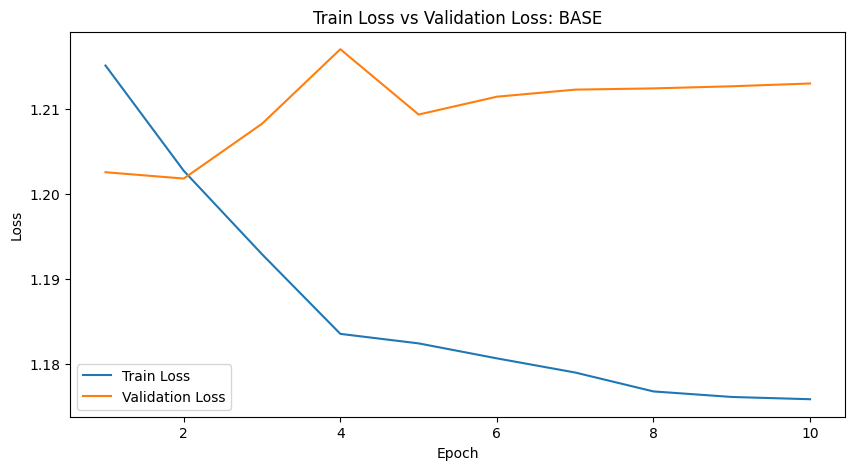

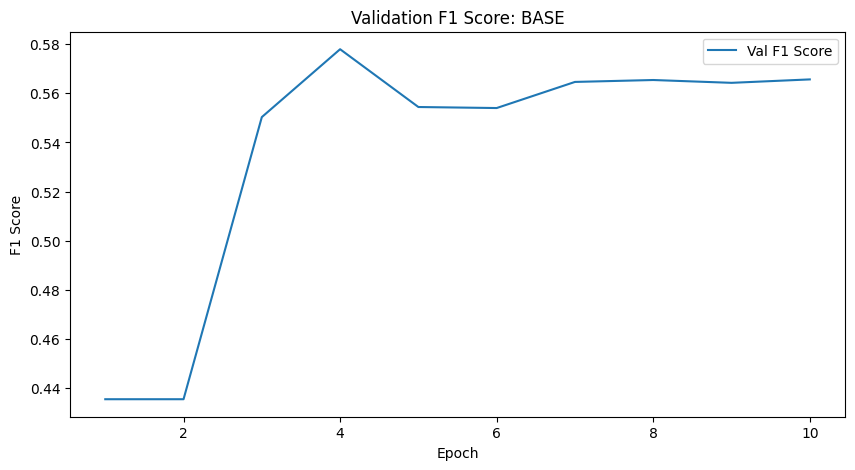

----------------------------------------------------------------------------------------------------
############################## Run with seed: 42 #######################################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 42  epochs: 10, batch_size: 64, dropout: 0.1,lr : 0.001,

MODEL CREATION
Done

Making Dir to save models...
Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.211722       1.204326         0.463590        0.476824  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.194031       1.233255         0.565819        0.547688  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.181503       1.214326         0.600990        0.528164  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.176730       1.218147         0.623966        0.469767  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.174360       1.207877         0.624354        0.448793  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.173718       1.231022         0.631958        0.511277  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.170928       1.271832         0.639368        0.564094  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.170619       1.265126         0.639644        0.576148  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.168151       1.260560         0.638974        0.560790  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.166801       1.259639         0.643538        0.558799  

Cleaning CUDA memory...

Cleaning Done!
############################## Training 42 done. #######################################################


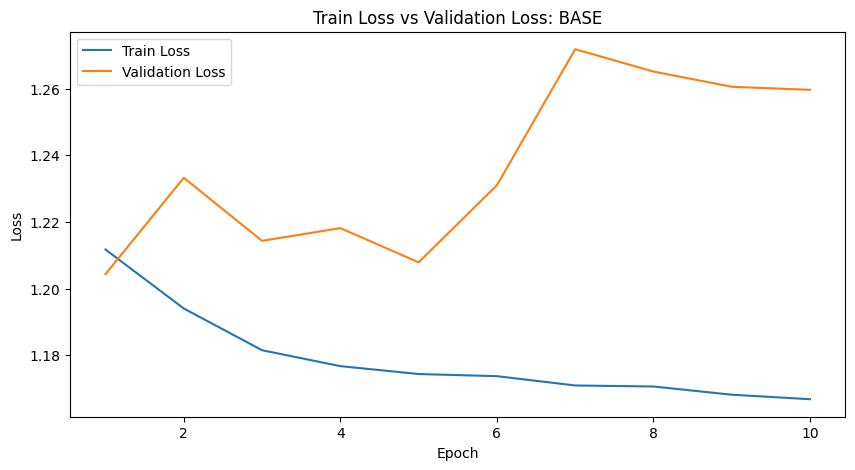

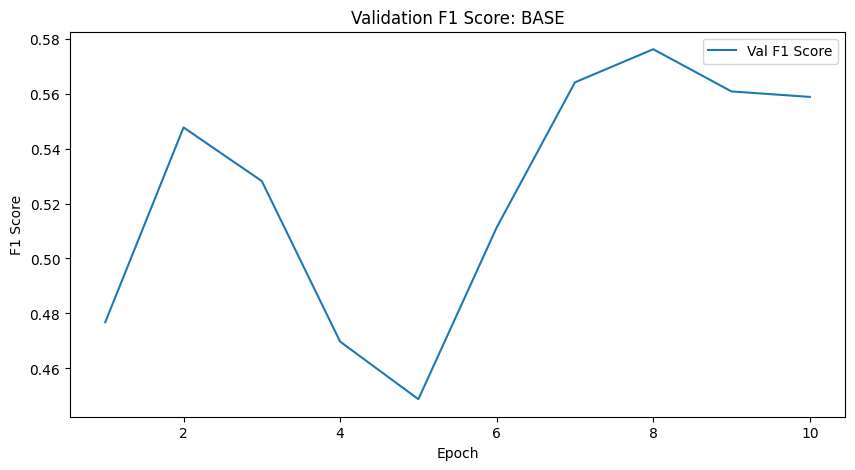

----------------------------------------------------------------------------------------------------
############################## Run with seed: 121 #######################################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 121  epochs: 10, batch_size: 64, dropout: 0.1,lr : 0.001,

MODEL CREATION
Done

Making Dir to save models...
Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.209964       1.197256         0.469504        0.481579  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.197765       1.196295         0.529315        0.491981  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.190420       1.199963         0.546040        0.551282  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.188657       1.203396         0.592219        0.458460  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.184734       1.200359         0.587442        0.561495  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.181873       1.201992         0.599763        0.566125  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.178524       1.202792         0.594514        0.566192  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.176567       1.219614         0.610200        0.569123  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.171972       1.204970         0.628771        0.562741  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.172352       1.209627         0.625941        0.563436  

Cleaning CUDA memory...

Cleaning Done!
############################## Training 121 done. #######################################################


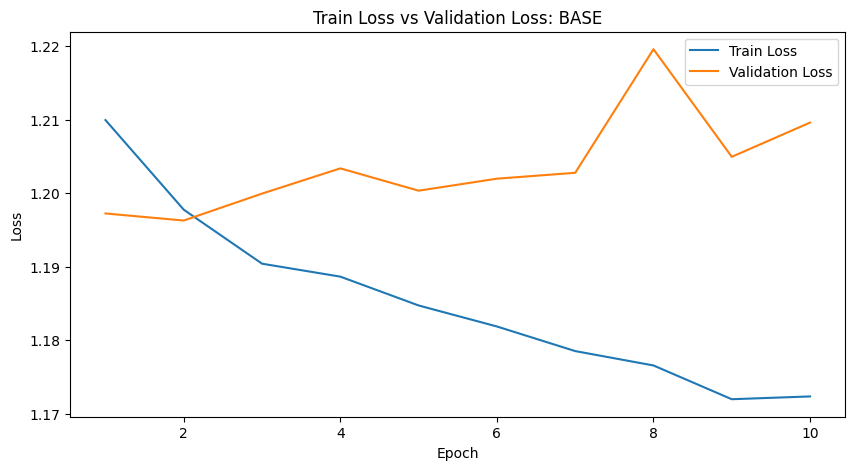

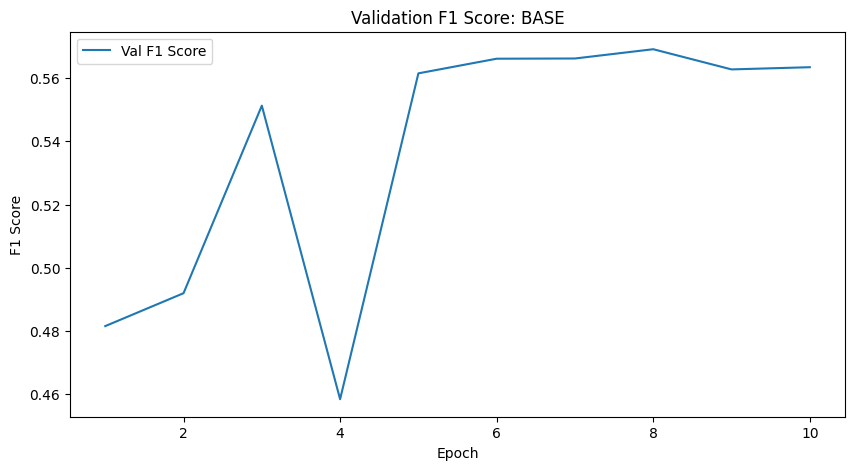

In [39]:
SEED = [0,42,121]
DROPOUT = 0.1
LEARNING_RATE = 1e-03
save = True
model_type = 'base'

for seed in SEED:
      print("-"*100)
      print(f"############################## Run with seed: {seed} #######################################################")

      print(f"Setting seed for reproducibility")
      set_reproducibility(seed)
      print("Done")
      print()

      print("SELECTED HYPERPARAMETERS")
      hyp_str = f"run_num: {seed}  epochs: {EPOCHS}, batch_size: {TRAIN_BATCH_SIZE}, dropout: {DROPOUT},lr : {LEARNING_RATE},"
      print(hyp_str)
      print()

      print("MODEL CREATION")
      model = MultilabelClassifier(drop_out=DROPOUT, num_labels = NUM_LABELS, model_type="base")
      model.to(device)
      print("Done")
      print()

      loss_fn = WeightedLoss(class_weights=torch.tensor(compute_class_weights_from_df(train_df_to_ds), dtype=torch.float32))

      if save:
        print("Making Dir to save models...")
        path_to_ckp = 'ckp_' + model_type
        if not os.path.exists(path_to_ckp):
            os.makedirs(path_to_ckp)
        hyp_path = os.path.join(path_to_ckp, 'hyp.txt')
        with open(hyp_path, "w") as f:
            f.write(str(hyp_str))
        print("Done")
        print()

      print("START TRAINING")
      print()
      history = train_and_validate(EPOCHS,model,train_loader,val_loader,loss_fn,seed,path_to_ckp = path_to_ckp ,load_model=False)


      print(f"Cleaning {str.upper(device)} memory...")
      print()
      del model
      torch.cuda.empty_cache()
      print("Cleaning Done!")


      print(f"############################## Training {seed} done. #######################################################")

      plot_history(EPOCHS,history,"base")


## Training CP MODEL

In [40]:
wcp_datasets = DatasetDict()
wcp_datasets['train'] = MultilabelDataset(train_df_to_ds, tokenizer, WCP_MAX_LEN)
wcp_datasets['validation'] = MultilabelDataset(val_df_to_ds, tokenizer, WCP_MAX_LEN)
wcp_datasets['test'] = MultilabelDataset(test_df_to_ds, tokenizer, WCP_MAX_LEN)

train_loader_cp =  DataLoader(wcp_datasets['train'], batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader_cp = DataLoader(wcp_datasets['validation'], batch_size=VALID_BATCH_SIZE, shuffle=False)

----------------------------------------------------------------------------------------------------
############################## Run with seed: 0 #######################################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 0  epochs: 10, batch_size: 64, dropout: 0.2,lr : 0.001,

MODEL CREATION
Done

Making Dir to save models...
Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.213853       1.201102         0.440777        0.471406  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.201653       1.195152         0.512526        0.478462  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.193102       1.202486         0.544580        0.556633  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.186987       1.202802         0.558793        0.556252  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.182887       1.208687         0.597268        0.570957  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.181845       1.204040         0.576622        0.553713  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.179022       1.203625         0.597696        0.551556  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.177482       1.202469         0.601786        0.551106  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.177751       1.202507         0.600494        0.550032  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.176147       1.202018         0.605318        0.548315  

Cleaning CUDA memory...

Cleaning Done!
############################## Training 0 done. #######################################################


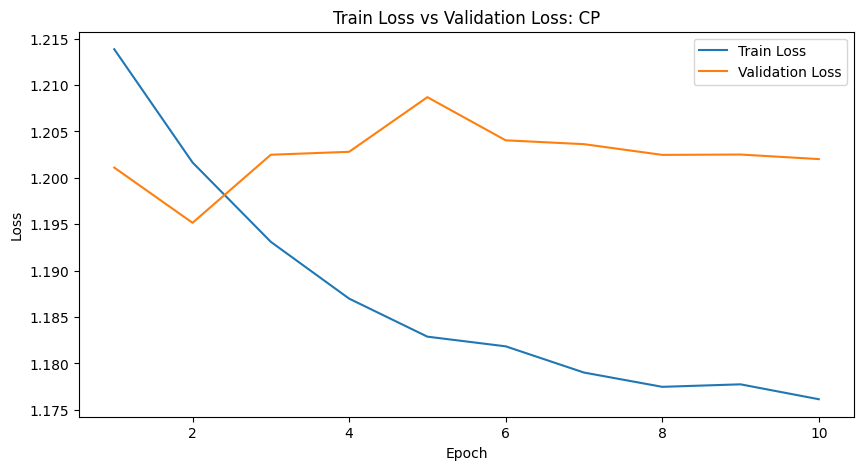

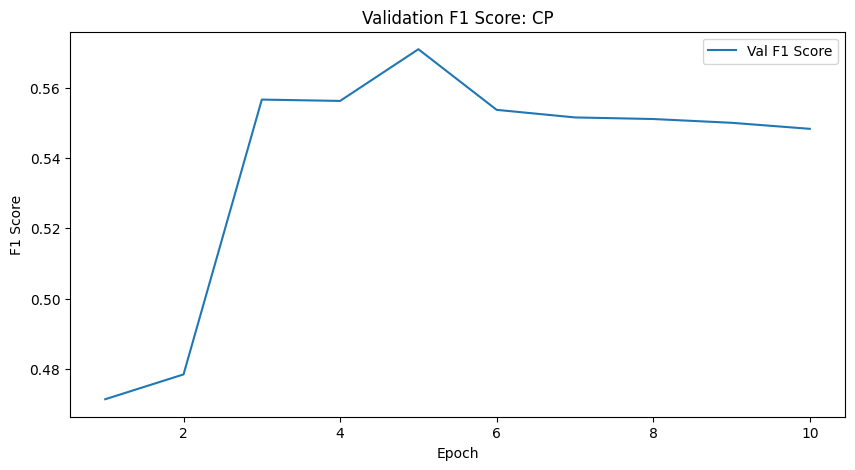

----------------------------------------------------------------------------------------------------
############################## Run with seed: 42 #######################################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 42  epochs: 10, batch_size: 64, dropout: 0.2,lr : 0.001,

MODEL CREATION
Done

Making Dir to save models...
Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.211192       1.197973         0.455447        0.475751  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.186686       1.209978         0.576101        0.509917  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.179651       1.214040         0.614749        0.559140  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.176537       1.203182         0.627088        0.474452  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.173518       1.226125         0.637435        0.551349  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.171654       1.215794         0.641536        0.536993  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.170558       1.229500         0.639004        0.514022  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.169716       1.230652         0.638453        0.535063  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.168841       1.225010         0.645406        0.515394  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.167086       1.226842         0.647389        0.520846  

Cleaning CUDA memory...

Cleaning Done!
############################## Training 42 done. #######################################################


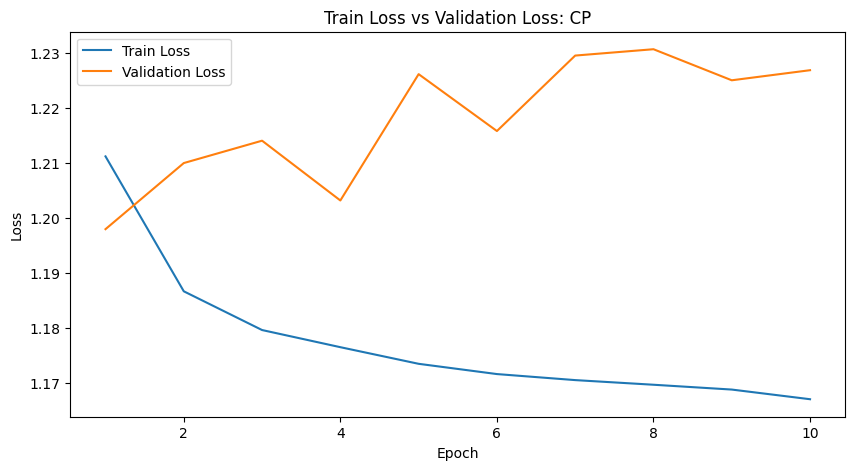

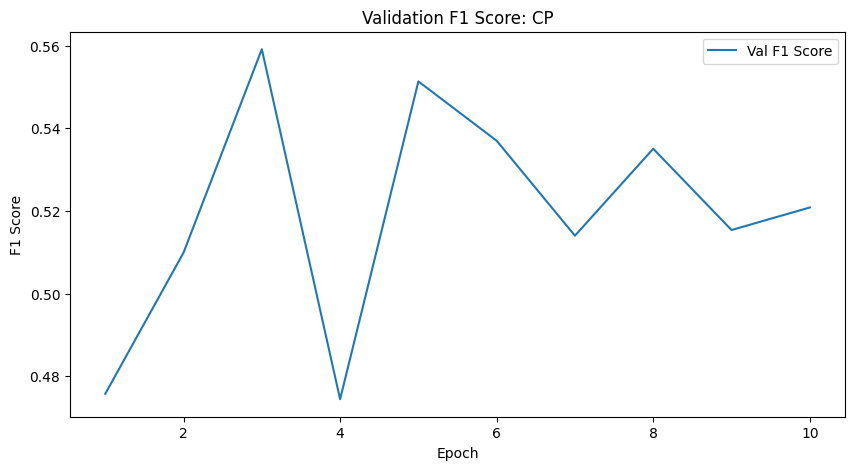

----------------------------------------------------------------------------------------------------
############################## Run with seed: 121 #######################################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 121  epochs: 10, batch_size: 64, dropout: 0.2,lr : 0.001,

MODEL CREATION
Done

Making Dir to save models...
Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.213504       1.201641         0.434028        0.435422  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.206869       1.194622         0.459704        0.473601  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.201750       1.196563         0.514456        0.517007  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.191984       1.201040         0.562805        0.494858  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.188802       1.203717         0.575213        0.541306  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.184344       1.198519         0.590171        0.534581  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.183416       1.200466         0.599084        0.467794  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.183221       1.199897         0.592294        0.533142  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.180749       1.201555         0.602062        0.502234  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.181175       1.201540         0.608036        0.502361  

Cleaning CUDA memory...

Cleaning Done!
############################## Training 121 done. #######################################################


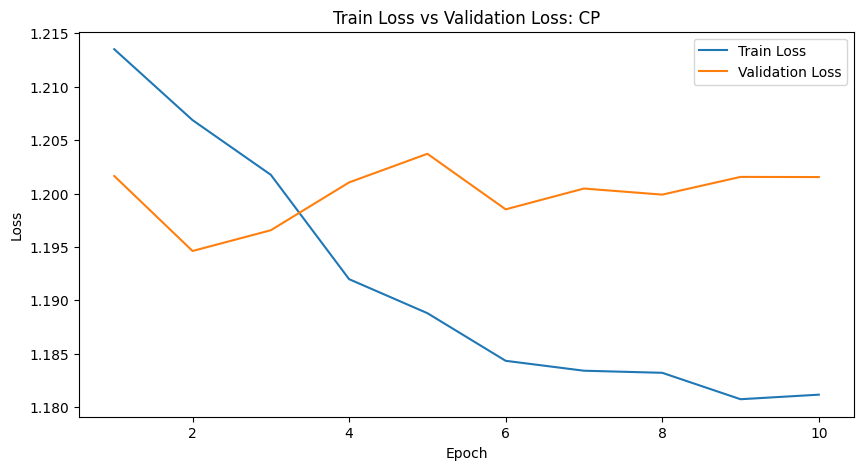

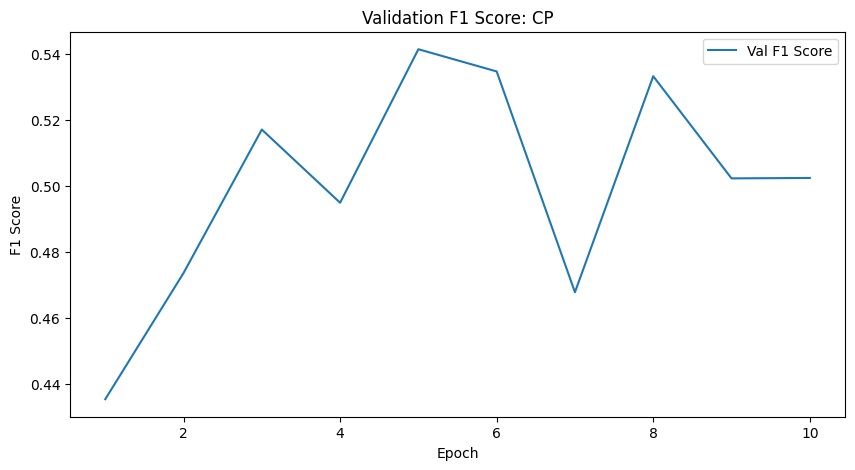

In [41]:
SEED = [0,42,121]
DROPOUT = 0.2
LEARNING_RATE = 1e-03
save = True
model_type = "berta_w_cp"


for seed in SEED:
      print("-"*100)
      print(f"############################## Run with seed: {seed} #######################################################")

      print(f"Setting seed for reproducibility")
      set_reproducibility(seed)
      print("Done")
      print()

      print("SELECTED HYPERPARAMETERS")
      hyp_str = f"run_num: {seed}  epochs: {EPOCHS}, batch_size: {TRAIN_BATCH_SIZE}, dropout: {DROPOUT},lr : {LEARNING_RATE},"
      print(hyp_str)
      print()

      print("MODEL CREATION")
      model = MultilabelClassifier(drop_out=DROPOUT, num_labels = NUM_LABELS, model_type=model_type)
      model.to(device)
      print("Done")
      print()

      loss_fn = WeightedLoss(class_weights=torch.tensor(compute_class_weights_from_df(train_df_to_ds), dtype=torch.float32))

      if save:
        print("Making Dir to save models...")
        path_to_ckp = 'ckp_' + model_type
        if not os.path.exists(path_to_ckp):
            os.makedirs(path_to_ckp)
        hyp_path = os.path.join(path_to_ckp, 'hyp.txt')
        with open(hyp_path, "w") as f:
            f.write(str(hyp_str))
        print("Done")
        print()

      print("START TRAINING")
      print()
      history = train_and_validate(EPOCHS,model,train_loader_cp,val_loader_cp,loss_fn,seed,path_to_ckp=path_to_ckp,load_model=False)


      print(f"Cleaning {str.upper(device)} memory...")
      print()
      del model
      torch.cuda.empty_cache()
      print("Cleaning Done!")


      print(f"############################## Training {seed} done. #######################################################")

      plot_history(EPOCHS,history,model_type='cp')


## Training CPS MODEL

In [42]:
wcps_datasets = DatasetDict()
wcps_datasets['train'] = MultilabelDataset(train_df_to_ds, tokenizer, WCPS_MAX_LEN)
wcps_datasets['validation'] = MultilabelDataset(val_df_to_ds, tokenizer, WCPS_MAX_LEN)
wcps_datasets['test'] = MultilabelDataset(test_df_to_ds, tokenizer, WCPS_MAX_LEN)

train_loader_cps =  DataLoader(wcp_datasets['train'], batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader_cps = DataLoader(wcp_datasets['validation'], batch_size=VALID_BATCH_SIZE, shuffle=False)

----------------------------------------------------------------------------------------------------
############################## Run with seed: 0 #######################################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 0  epochs: 10, batch_size: 64, dropout: 0.0,lr : 0.001,

MODEL CREATION
Done

Making Dir to save models...
Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.213139       1.193511         0.445061        0.500505  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.196670       1.190962         0.538018        0.500028  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.189110       1.204705         0.553080        0.537002  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.184034       1.196733         0.603550        0.488607  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.175708       1.256564         0.626340        0.567783  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.172179       1.245536         0.636876        0.573657  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.172236       1.234340         0.641593        0.561684  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.169854       1.230370         0.645915        0.562913  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.168849       1.237365         0.649893        0.565321  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.166687       1.236109         0.649292        0.601938  

Cleaning CUDA memory...

Cleaning Done!
############################## Training 0 done. #######################################################


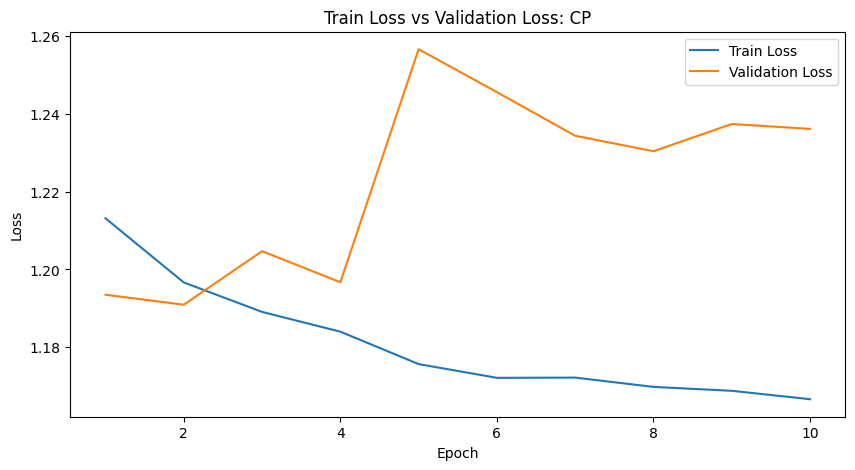

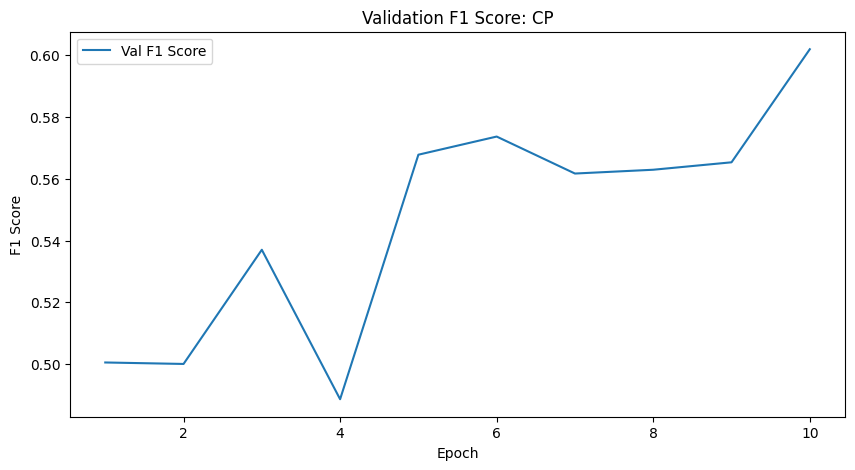

----------------------------------------------------------------------------------------------------
############################## Run with seed: 42 #######################################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 42  epochs: 10, batch_size: 64, dropout: 0.0,lr : 0.001,

MODEL CREATION
Done

Making Dir to save models...
Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.208277       1.198252         0.469966        0.487941  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.185299       1.203069         0.608550        0.459760  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.180187       1.207058         0.622864        0.530664  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.173654       1.204900         0.639896        0.460658  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.172903       1.207397         0.633378        0.488145  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.172928       1.201770         0.645185        0.464057  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.171237       1.206118         0.647305        0.499723  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.169840       1.199973         0.645942        0.475742  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.169659       1.202032         0.642275        0.472615  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.167213       1.202200         0.642434        0.472508  

Cleaning CUDA memory...

Cleaning Done!
############################## Training 42 done. #######################################################


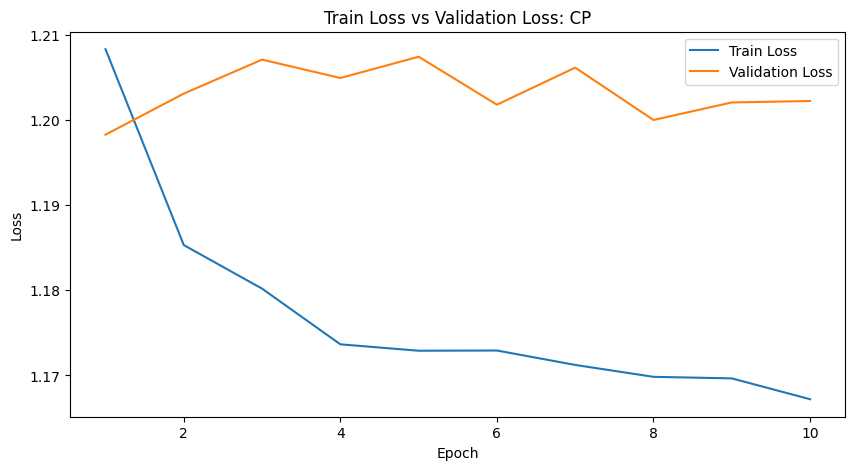

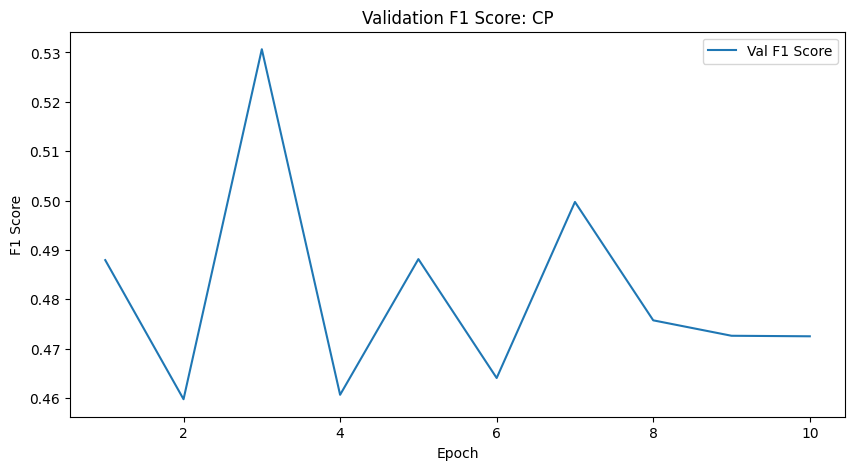

----------------------------------------------------------------------------------------------------
############################## Run with seed: 121 #######################################################
Setting seed for reproducibility
Done

SELECTED HYPERPARAMETERS
run_num: 121  epochs: 10, batch_size: 64, dropout: 0.0,lr : 0.001,

MODEL CREATION
Done

Making Dir to save models...
Done

START TRAINING



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
1     1.213325       1.201625         0.434149        0.435422  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
2     1.203835       1.225603         0.489882        0.511370  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
3     1.192585       1.224834         0.567264        0.511126  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
4     1.187203       1.205290         0.590475        0.458606  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
5     1.189142       1.220058         0.567991        0.539599  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
6     1.182795       1.214603         0.607045        0.535919  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
7     1.180488       1.216328         0.598852        0.536553  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
8     1.179159       1.212801         0.599796        0.511827  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
9     1.178037       1.212744         0.596659        0.500433  



  0%|          | 0/85 [00:00<?, ?it/s]

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch Training Loss  Validation Loss  Macro F1        Val Macro F1
10    1.177909       1.212967         0.605592        0.501495  

Cleaning CUDA memory...

Cleaning Done!
############################## Training 121 done. #######################################################


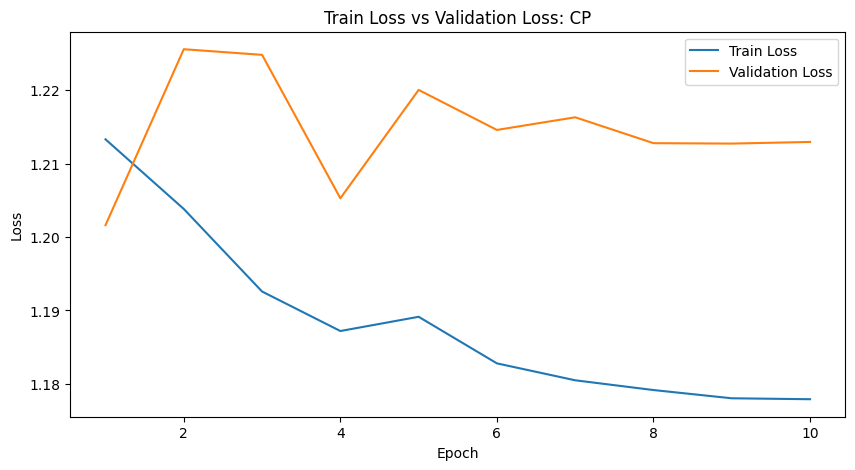

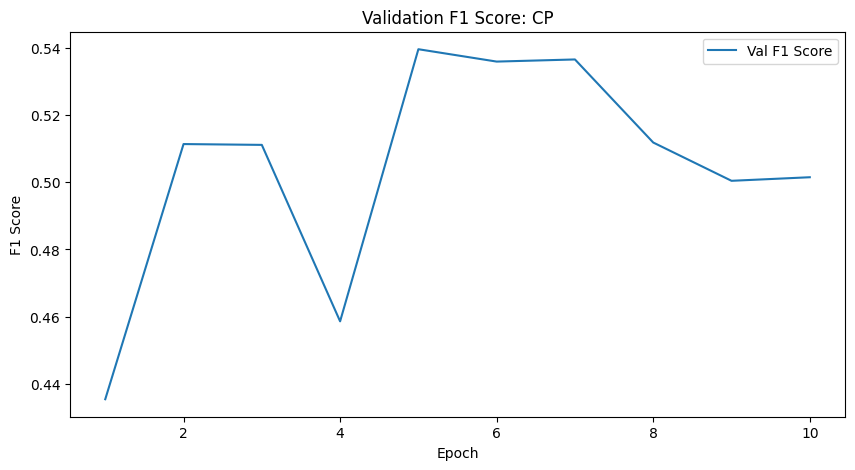

In [43]:
SEED = [0,42,121]
DROPOUT=0.
LEARNING_RATE = 1e-03
save = True
model_type = "berta_w_cps"

for seed in SEED:
      print("-"*100)
      print(f"############################## Run with seed: {seed} #######################################################")

      print(f"Setting seed for reproducibility")
      set_reproducibility(seed)
      print("Done")
      print()

      print("SELECTED HYPERPARAMETERS")
      hyp_str = f"run_num: {seed}  epochs: {EPOCHS}, batch_size: {TRAIN_BATCH_SIZE}, dropout: {DROPOUT},lr : {LEARNING_RATE},"
      print(hyp_str)
      print()

      print("MODEL CREATION")
      model = MultilabelClassifier(drop_out=DROPOUT, num_labels = NUM_LABELS, model_type=model_type)
      model.to(device)
      print("Done")
      print()

      loss_fn = WeightedLoss(class_weights=torch.tensor(compute_class_weights_from_df(train_df_to_ds), dtype=torch.float32))

      if save:
        print("Making Dir to save models...")
        path_to_ckp = 'ckp_' + model_type
        if not os.path.exists(path_to_ckp):
            os.makedirs(path_to_ckp)
        hyp_path = os.path.join(path_to_ckp, 'hyp.txt')
        with open(hyp_path, "w") as f:
            f.write(str(hyp_str))
        print("Done")
        print()

      print("START TRAINING")
      print()
      history = train_and_validate(EPOCHS,model,train_loader_cp,val_loader_cp,loss_fn,seed,path_to_ckp=path_to_ckp,load_model=False)


      print(f"Cleaning {str.upper(device)} memory...")
      print()
      del model
      torch.cuda.empty_cache()
      print("Cleaning Done!")


      print(f"############################## Training {seed} done. #######################################################")

      plot_history(EPOCHS,history,model_type='cp')


In [ ]:
!zip -r /content/ckp_base.zip /content/ckp_base

from google.colab import files
files.download("/content/ckp_base.zip")


  adding: content/ckp_base/ (stored 0%)
  adding: content/ckp_base/best_weigths_seed121.tar (deflated 61%)
  adding: content/ckp_base/best_weigths_seed0.tar (deflated 61%)
  adding: content/ckp_base/best_weigths_seed42.tar (deflated 61%)
  adding: content/ckp_base/hyp.txt (deflated 3%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/ckp_berta_w_cp.zip /content/ckp_berta_w_cp

from google.colab import files
files.download("/content/ckp_berta_w_cp.zip")

updating: content/ckp_berta_w_cp/ (stored 0%)
updating: content/ckp_berta_w_cp/hyp.txt (deflated 3%)
  adding: content/ckp_berta_w_cp/best_weigths_seed121.tar (deflated 48%)
  adding: content/ckp_berta_w_cp/best_weigths_seed0.tar (deflated 48%)
  adding: content/ckp_berta_w_cp/best_weigths_seed42.tar (deflated 48%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/ckp_berta_w_cps.zip /content/ckp_berta_w_cps

from google.colab import files
files.download("/content/ckp_berta_w_cps.zip")

updating: content/ckp_berta_w_cps/ (stored 0%)
updating: content/ckp_berta_w_cps/hyp.txt (deflated 5%)
  adding: content/ckp_berta_w_cps/best_weigths_seed121.tar (deflated 48%)
  adding: content/ckp_berta_w_cps/best_weigths_seed0.tar (deflated 48%)
  adding: content/ckp_berta_w_cps/best_weigths_seed42.tar (deflated 48%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
def load_best_model(path: str,
                    model_type: str,
                    dropout: float = 0.,
                    stats: bool = True
                     ):
      '''
      Loads the checkpoints for the three seeds, compute
      the mean and std of the results on validation and then
      return the best one.

      :param path: path to checkpoints folder
      :param model_name: name of the model
      :params hyperparameters of the model
      :param stats: print mean and std

      :return
           best_model: the best bert-model over the 3 seeds
           mean_f1_macro: average F1 measure over the 3 seeds
      '''
      checkpoints = []
      losses = []
      f1_macros = []
      max_f1 = 0
      max_seed = SEED[0]
      max_idx = 0

      for i,seed in enumerate(SEED):

        ckp = torch.load(path + f"/best_weigths_seed{seed}.tar")
        f1_val = ckp['val_f1']
        checkpoints.append(ckp)
        losses.append(ckp['val_loss'])
        f1_macros.append(f1_val)

        if f1_val > max_f1: # finding the max
          max_f1 = f1_val
          max_seed = seed
          max_idx = i

      # some statistics
      mean_loss = np.mean([loss.item() for loss in losses])
      std_loss  = np.std([loss.item() for loss in losses])
      mean_f1_macro = np.mean(f1_macros)
      std_f1_macro  = np.std(f1_macros)

      if stats:
          print(f"\tStatistics over the three seeds for model {model_type}")
          print(f"\tMean loss    : {mean_loss:.4f}  Std: {std_loss:.4f}")
          print(f"\tMean f1_macro: {mean_f1_macro:.4f}  Std: {std_f1_macro:.4f}")

      print(f"\tBest model has seed: {max_seed} and macro-f1: {max_f1:.3f}")
      print()


      best_model = MultilabelClassifier(drop_out=DROPOUT, num_labels = NUM_LABELS, model_type=model_type)

      best_model.load_state_dict(checkpoints[max_idx]['model_state_dict'])

      return best_model, mean_f1_macro

In [37]:
random_model = RandomUniformClassifier(NUM_LABELS).to(device)
majority_model = MajorityClassifier(NUM_LABELS).to(device)
majority_model.fit(train_loader)
loss_fn = WeightedLoss(class_weights=torch.tensor(compute_class_weights_from_df(train_df_to_ds), dtype=torch.float32))



eval_result_random = train_and_validate(EPOCHS,random_model,train_loader,val_loader,loss_fn,seed=0,path_to_ckp=None,load_model=False,eval_only = True)
f1_random = eval_result_random['val_f1_scores'][0]
print(f"Random model macro f1: {f1_random:.6f}")
print()

eval_result_majority = train_and_validate(EPOCHS,majority_model,train_loader,val_loader,loss_fn,seed=0,path_to_ckp=None,load_model=False,eval_only = True)
f1_majority = eval_result_majority['val_f1_scores'][0]
print(f"Majority model macro f1: {f1_majority:.6f}")

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Validation Loss     Val Macro F1        
1.343606            0.523609            

Random model macro f1: 0.523609

Starting the evaluation ...


  0%|          | 0/30 [00:00<?, ?it/s]

Validation Loss     Val Macro F1        
1.201212            0.435422            

Majority model macro f1: 0.435422


In [44]:
best_bert_base, f1_base = load_best_model(path = "/content/ckp_base", model_type='base', dropout=0.1)
best_bert_m1, f1_m1     = load_best_model(path = "/content/ckp_berta_w_cp", model_type='berta_w_cp', dropout=0.2)
best_bert_m2, f1_m2     = load_best_model(path = "/content/ckp_berta_w_cps", model_type='berta_w_cps', dropout=0.)

	Statistics over the three seeds for model base
	Mean loss    : 1.1057  Std: 0.0093
	Mean f1_macro: 0.5626  Std: 0.0029
	Best model has seed: 0 and macro-f1: 0.566

	Statistics over the three seeds for model berta_w_cp
	Mean loss    : 1.1042  Std: 0.0103
	Mean f1_macro: 0.5238  Std: 0.0189
	Best model has seed: 0 and macro-f1: 0.548

	Statistics over the three seeds for model berta_w_cps
	Mean loss    : 1.1064  Std: 0.0020
	Mean f1_macro: 0.5253  Std: 0.0555
	Best model has seed: 0 and macro-f1: 0.602



In [45]:
loss_function = torch.nn.BCEWithLogitsLoss()
y_val = wcps_datasets['validation'].labels.numpy()
threshold = 0.5


models_zoo = {
    'baseline_random':random_model,
    'baseline_majority':majority_model,
    'bert_base':best_bert_base,
    'bert_cp':best_bert_m1,
    'bert_cps':best_bert_m2
}

models_f1 = {'baseline_random':f1_random,
             'baseline_majority':f1_majority,
             'bert_base':f1_base,
             'bert_cp':f1_m1,
             'bert_cps':f1_m2
            }

In [71]:
def predict(
      model: nn.Module,
      dataloader: torch.utils.data.DataLoader
    ) -> torch.tensor:

    '''
    Compute the forward pass and return a tensor on the cpu with the prediction
    for the whole dataloader, there is risk of memory overflow.

    @param model: torch model to calculate the predictions
    @param dataloader: torch loader to get the data
    '''

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to(device)
    len_dataset = len(dataloader.dataset.labels)
    true_labels = torch.zeros((len_dataset, 4))

    predictions_epoch = torch.zeros((len_dataset, 4))

    batch_size = dataloader.batch_size

    with torch.no_grad():
        for batch_indx, batch in tqdm(enumerate(dataloader)):

            cur_batch_size = batch['ids_c'].shape[0]
            targets = batch['labels'].to(device)


            # Forward pass
            outputs = model(batch)

            # Accumulation
            predictions_epoch[batch_indx * batch_size : batch_indx*batch_size + cur_batch_size] = outputs
            true_labels[batch_indx * batch_size : batch_indx*batch_size + cur_batch_size] = targets


    return predictions_epoch.numpy()



In [72]:
f1_list = []
LABELS = ['openness_to_change', 'self_enhancement', 'conservation', 'self_transcendence']
for i, (name, model) in enumerate(models_zoo.items()):

    preds = predict(model, val_loader)
    bin_preds = (preds > threshold).astype(int)




    f1_labels = f1_score(y_val, bin_preds, average=None)
    f1_per_category = {LABELS[i]: f1_labels[i] for i in range(NUM_LABELS)}

    f1_list.append(f1_per_category)

    print()
    print(f'\t\t\t {name.upper()}')
    print(classification_report(y_val, bin_preds, target_names=LABELS,zero_division=False))
    print()
    print('-'*100)



0it [00:00, ?it/s]


			 BASELINE_RANDOM
                    precision    recall  f1-score   support

openness_to_change       0.38      0.52      0.44       698
  self_enhancement       0.46      0.49      0.47       885
      conservation       0.76      0.51      0.61      1426
self_transcendence       0.81      0.52      0.63      1506

         micro avg       0.61      0.51      0.55      4515
         macro avg       0.60      0.51      0.54      4515
      weighted avg       0.66      0.51      0.57      4515
       samples avg       0.57      0.51      0.50      4515


----------------------------------------------------------------------------------------------------


0it [00:00, ?it/s]


			 BASELINE_MAJORITY
                    precision    recall  f1-score   support

openness_to_change       0.00      0.00      0.00       698
  self_enhancement       0.00      0.00      0.00       885
      conservation       0.75      1.00      0.86      1426
self_transcendence       0.79      1.00      0.89      1506

         micro avg       0.77      0.65      0.71      4515
         macro avg       0.39      0.50      0.44      4515
      weighted avg       0.50      0.65      0.57      4515
       samples avg       0.77      0.68      0.70      4515


----------------------------------------------------------------------------------------------------


0it [00:00, ?it/s]


			 BERT_BASE
                    precision    recall  f1-score   support

openness_to_change       0.00      0.00      0.00       698
  self_enhancement       0.57      0.51      0.54       885
      conservation       0.75      0.99      0.86      1426
self_transcendence       0.79      1.00      0.89      1506

         micro avg       0.74      0.75      0.74      4515
         macro avg       0.53      0.63      0.57      4515
      weighted avg       0.61      0.75      0.67      4515
       samples avg       0.74      0.77      0.73      4515


----------------------------------------------------------------------------------------------------


0it [00:00, ?it/s]


			 BERT_CP
                    precision    recall  f1-score   support

openness_to_change       0.00      0.00      0.00       698
  self_enhancement       0.62      0.42      0.50       885
      conservation       0.78      0.86      0.81      1426
self_transcendence       0.79      1.00      0.89      1506

         micro avg       0.76      0.69      0.72      4515
         macro avg       0.55      0.57      0.55      4515
      weighted avg       0.63      0.69      0.65      4515
       samples avg       0.76      0.71      0.71      4515


----------------------------------------------------------------------------------------------------


0it [00:00, ?it/s]


			 BERT_CPS
                    precision    recall  f1-score   support

openness_to_change       0.40      0.42      0.41       698
  self_enhancement       0.67      0.32      0.43       885
      conservation       0.76      0.92      0.84      1426
self_transcendence       0.79      0.82      0.80      1506

         micro avg       0.70      0.69      0.70      4515
         macro avg       0.66      0.62      0.62      4515
      weighted avg       0.70      0.69      0.68      4515
       samples avg       0.71      0.72      0.68      4515


----------------------------------------------------------------------------------------------------


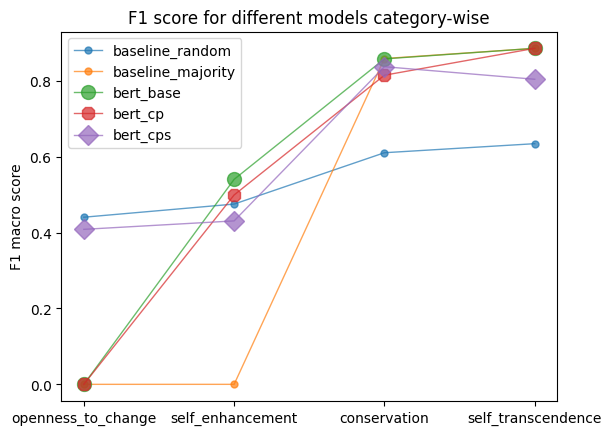

In [73]:
markers = [".", ".", "o", "8", "D"]
for i, (name, model) in enumerate(models_zoo.items()):
    plt.plot(f1_list[i].keys(),
             f1_list[i].values(),
             marker=markers[i],
             alpha=.7, ms=10, lw=1
      )

plt.legend(list(models_zoo.keys()))
plt.ylabel("F1 macro score")
plt.title("F1 score for different models category-wise")
plt.show()

In [74]:
best_model_key = max(models_f1, key=lambda k: models_f1[k])
print(f'The best model is {best_model_key}')
best_model = models_zoo[best_model_key]

The best model is bert_base


In [76]:
test_loader =  DataLoader(wc_datasets['test'], batch_size=64, shuffle=False)
y_test = wcps_datasets['test'].labels.numpy()
threshold = 0.5

In [77]:
preds = predict(model, test_loader)
bin_preds = (preds > threshold).astype(int)

f1_labels = f1_score(y_test, bin_preds, average=None)
f1_per_category = {LABELS[i]: f1_labels[i] for i in range(NUM_LABELS)}

print()
print(f'\t\t\t {name.upper()}')
print(classification_report(y_test, bin_preds,target_names=LABELS))
print()
print('-'*100)

0it [00:00, ?it/s]


			 BERT_CPS
                    precision    recall  f1-score   support

openness_to_change       0.86      0.01      0.02       474
  self_enhancement       0.49      0.19      0.27       647
      conservation       0.71      0.97      0.82      1119
self_transcendence       0.81      0.99      0.89      1268

         micro avg       0.74      0.71      0.72      3508
         macro avg       0.72      0.54      0.50      3508
      weighted avg       0.72      0.71      0.64      3508
       samples avg       0.75      0.74      0.71      3508


----------------------------------------------------------------------------------------------------


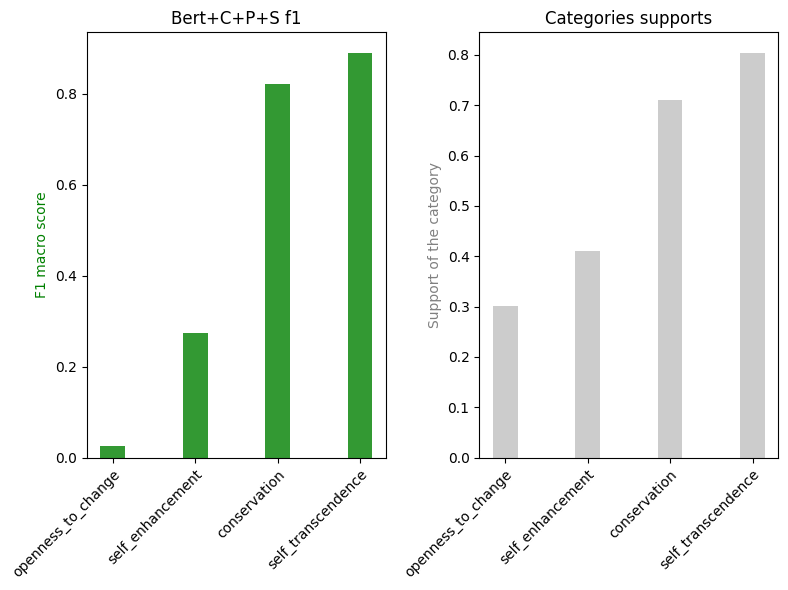

In [79]:
fig, ax1 = plt.subplots(1, 2, figsize=(8, 6))

percentages = torch.sum(wcps_datasets['test'].labels, dim=0) / len(wcps_datasets['test'])

ax1[0].bar(f1_per_category.keys(),
        f1_per_category.values(),
        width=0.3, color="green", alpha=0.8
)
ax1[0].set_ylabel("F1 macro score", color="green")
ax1[0].set_xticks(range(len(f1_per_category)))
ax1[0].set_xticklabels(f1_per_category.keys(), rotation=45, ha='right', rotation_mode='anchor')

ax1[0].set_title("Bert+C+P+S f1")

ax1[1].bar(f1_per_category.keys(), percentages, color='grey', alpha=0.4, width=0.3)
ax1[1].set_ylabel("Support of the category", color="grey")
ax1[1].set_xticks(range(len(f1_per_category)))
ax1[1].set_xticklabels(f1_per_category.keys(), rotation=45, ha='right', rotation_mode='anchor')

ax1[1].set_title("Categories supports")
fig.tight_layout()
plt.show()

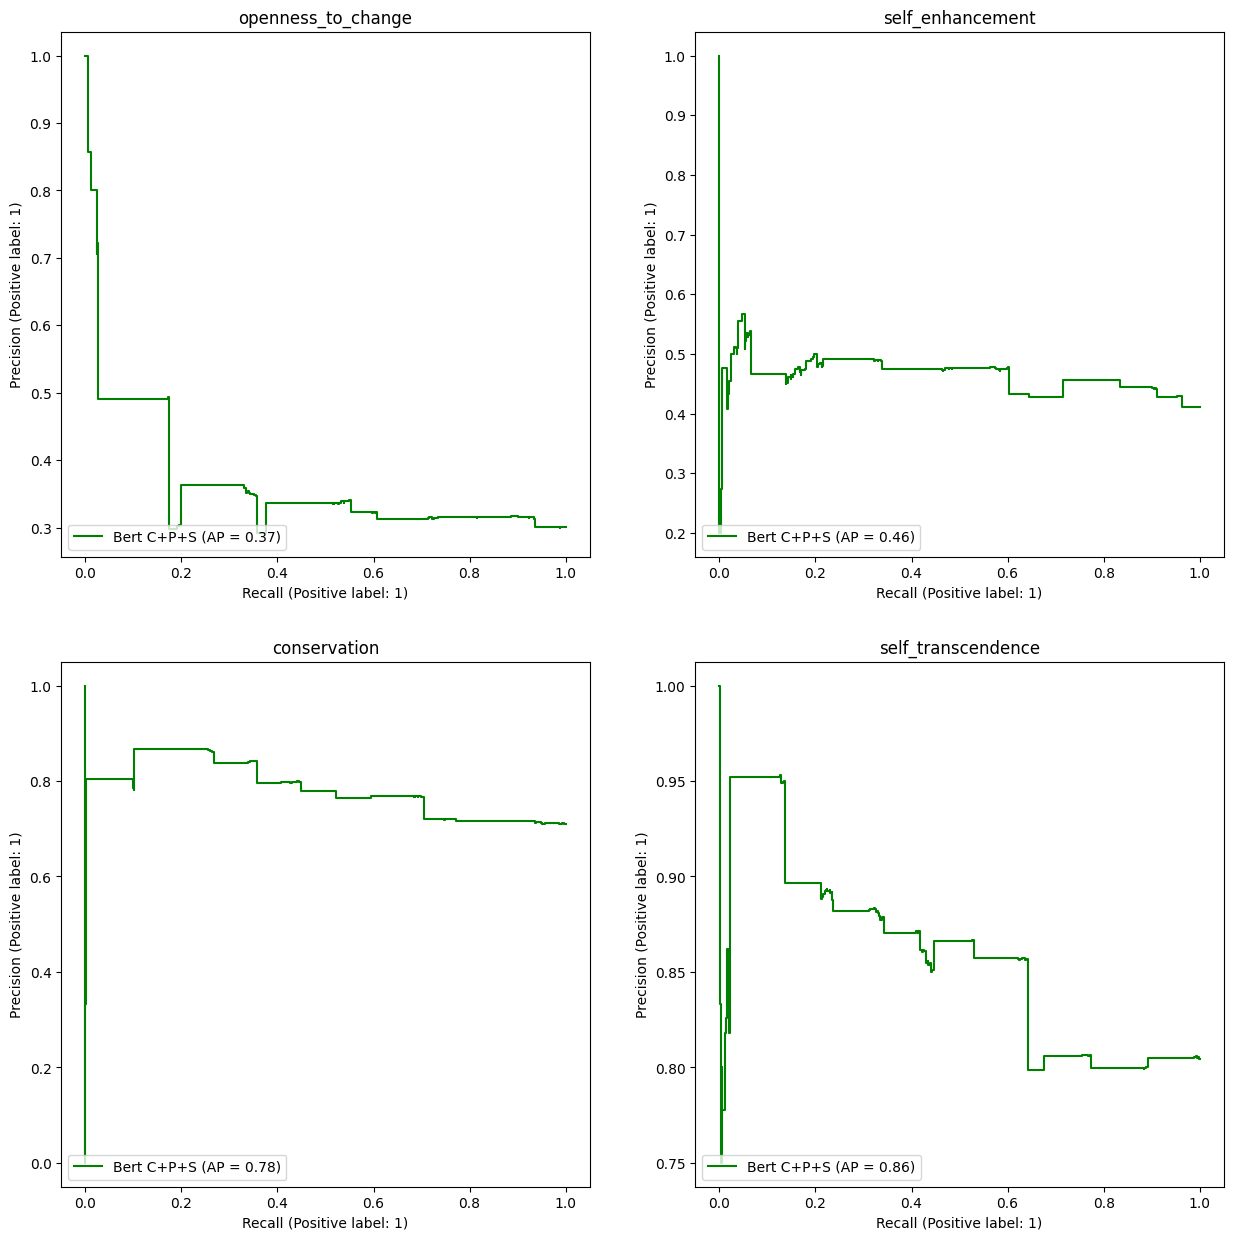

In [82]:
from sklearn.metrics import PrecisionRecallDisplay
plt.figure(figsize=(15, 15))

# Create subplots for precision-recall curves
for i in range(NUM_LABELS):
    ax = plt.subplot(2, 2, i+1)
    display = PrecisionRecallDisplay.from_predictions(y_test[:, i], preds[:, i], name="Bert C+P+S", ax = ax, color = "green")
    _ = display.ax_.set_title(LABELS[i])
plt.show()

In [96]:
preds = predict(best_model, test_loader)
bin_preds = (preds > threshold)

misclass = np.sum(bin_preds != y_test.astype(bool), axis=1)

idxs = np.argwhere(misclass > 0)


for i, el in enumerate(wcps_datasets['test']):

    if i in idxs[:10]:
      enc_sentence_prem = wcps_datasets['test'][i]['ids_p']
      enc_sentence_stan = wcps_datasets['test'][i]['stance']
      enc_sentence_conc = wcps_datasets['test'][i]['ids_c']

      stance = ('in favour of' if enc_sentence_stan else 'against')

      dec_sentence_prem =  tokenizer.decode(enc_sentence_prem, skip_special_tokens=True)
      dec_sentece_conc = tokenizer.decode(enc_sentence_conc, skip_special_tokens=True)

      dec_sentence_prem = dec_sentence_prem.split(" ")
      for j in range(20,len(dec_sentence_prem), 20):
              dec_sentence_prem.insert(j,'\n')
      dec_sentence_prem = " ".join(dec_sentence_prem)

      print("-"*100)
      print(f"Premise: {dec_sentence_prem}")
      print(f"Stance: {stance}")
      print(f"Conclusion: {dec_sentece_conc}\n")
      print(f"TRUE CLASSES: {np.array(LABELS)[y_test[i].astype(bool)]}")
      print(f"PRED CLASSES: {np.array(LABELS)[bin_preds[i].astype(bool)]}")
      print()

0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
Premise: affirmative action helps with employment equity.
Stance: against
Conclusion: we should end affirmative action

TRUE CLASSES: ['self_enhancement' 'conservation' 'self_transcendence']
PRED CLASSES: ['conservation' 'self_transcendence']

----------------------------------------------------------------------------------------------------
Premise: affirmative action can be considered discriminatory against poor whites
Stance: in favour of
Conclusion: we should end affirmative action

TRUE CLASSES: ['self_enhancement' 'self_transcendence']
PRED CLASSES: ['conservation' 'self_transcendence']

----------------------------------------------------------------------------------------------------
Premise: naturopathy is very dangerous for the most vulnerable people, like children and cancer patients. people use ineffective treatments and forgo 
 proven cures, such as antibiotics or chemo, 

KeyError: 1576

### Notes

**Do not mix models**. Each model has its own instructions.

You are **free** to select the BERT-based model card from huggingface.

#### Examples

```
bert-base-uncased
prajjwal1/bert-tiny
distilbert-base-uncased
roberta-base
```

### BERT w/ C

<center>
    <img src="images/bert_c.png" alt="BERT w/ C" />
</center>

### BERT w/ CP

<center>
    <img src="images/bert_cp.png" alt="BERT w/ CP" />
</center>

### BERT w/ CPS

<center>
    <img src="images/bert_cps.png" alt="BERT w/ CPS" />
</center>

### Input concatenation

<center>
    <img src="images/input_merging.png" alt="Input merging" />
</center>

### Notes

The **stance** input has to be encoded into a numerical format.

You **should** use the same model instance to encode **premise** and **conclusion** inputs.

# [Task 3 - 0.5 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Example

You start with individual predictions ($\rightarrow$ samples).

```
Openess to change:    0 0 1 0 1 1 0 ...
Self-enhancement:     1 0 0 0 1 0 1 ...
Conversation:         0 0 0 1 1 0 1 ...
Self-transcendence:   1 1 0 1 0 1 0 ...
```

You compute per-category binary F1-score.

```
Openess to change F1:    0.35
Self-enhancement F1:     0.55
Conversation F1:         0.80
Self-transcendence F1:   0.21
```

You then average per-category scores.
```
Average F1: ~0.48
```

# [Task 4 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

# [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

### Notes

You can check the [original paper](https://aclanthology.org/2022.acl-long.306/) for suggestions on how to perform comparisons (e.g., plots, tables, etc...).

# [Task 6 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Model card

You are **free** to choose the BERT-base model card you like from huggingface.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Model Training

You are **free** to choose training hyper-parameters for BERT-based models (e.g., number of epochs, etc...).

### Neural Libraries

You are **free** to use any library of your choice to address the assignment (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

# The End